## Plan
- create model
    - male or female
    - CH, AD, EL
- extract additive infomation
    - length
    - sceptrum infomation

In [1]:
import os 
import numpy as np
import pandas as pd
import librosa
import pyworld
import time
import shutil
import matplotlib.pyplot as plt

from tools import *
from model import *

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
seed_value = 0
np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [3]:
data_dir = "../data/NTT_corevo"

In [4]:
class_train = pd.read_csv(os.path.join(data_dir, "class_train.tsv"), delimiter='\t', header=None)
sample_submit = pd.read_csv(os.path.join(data_dir, "class_train.tsv"), delimiter='\t', header=None)

In [5]:
class_train.tail()

,0,1
37801,fff371f8fd363481780cf71abadd3912,FE_EL
37802,fffad7d70023ac8019976bfc7d9ba36d,MA_EL
37803,fffb68964f56e10022d62feba2e538d3,FE_AD
37804,fffdd34e46338d68f3eb7081b2c7f069,FE_AD
37805,ffff83dd1058ef7fd97151be4d61651f,MA_AD


In [6]:
sample_submit.head()

,0,1
0,0002f1cd968ca78ada9e1c7037224773,MA_CH
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD
2,0003b32f378b001f0f73bf0981da8773,MA_CH
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH
4,0005678b57ca265a65f8ef0cc7481277,MA_AD


In [7]:
class_train[class_train[0] == "fff371f8fd363481780cf71abadd3912"]

,0,1
37801,fff371f8fd363481780cf71abadd3912,FE_EL


In [8]:
train_data_dir = os.path.join(data_dir, "train")
files = os.listdir(train_data_dir)
list_label = []

if (False):
    if not os.path.exists(os.path.join(data_dir, "labeled/00/")):
        os.makedirs(os.path.join(data_dir, "labeled/00/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/01/")):
        os.makedirs(os.path.join(data_dir, "labeled/01/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/02/")):
        os.makedirs(os.path.join(data_dir, "labeled/02/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/03/")):
        os.makedirs(os.path.join(data_dir, "labeled/03/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/04/")):
        os.makedirs(os.path.join(data_dir, "labeled/04/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/05/")):
        os.makedirs(os.path.join(data_dir, "labeled/05/"))
    for file in files:
        file_id = file[:-4]
        label = class_train[class_train[0] == file_id].values[0,1]
        if (label == "FE_CH"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/00/" + file))
        elif (label == "FE_AD"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/01/" + file))
        elif (label == "FE_EL"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/02/" + file))
        elif (label == "MA_CH"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/03/" + file))
        elif (label == "MA_AD"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/04/" + file))
        elif (label == "MA_EL"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/05/" + file))

labels_num = np.zeros((6,))
for i in range(6):
    labels_num[i] = len(os.listdir(os.path.join(data_dir, "labeled/0" + str(i))))

## Labels
- 0: female child
- 1: female adult
- 2: female elder
- 3: male child
- 4: male adult
- 5: male elder

/home/takiguchi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


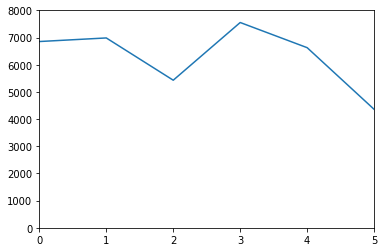

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(labels_num)
ax.set_xlim(0,5)
ax.set_ylim(0, 8000)
fig.show()

In [10]:
sampling_rate = 16000
num_mcep = 36
frame_period = 5.0
n_frames = 1024
num_label = 6

In [11]:
def data_load(batch_size = 1, label = -1, path=""):
    data_list = []
    label_list = []
    
    if (label == -1):
        random_label = True 
    else:
        random_label =  False
        
    for i in range(batch_size):
        
        if random_label :
            label = np.random.randint(0, num_label)
        
        if path == "":
            sample_data_dir = os.path.join(data_dir, "labeled/{:02}".format(label))
            file = np.random.choice(os.listdir(sample_data_dir))
        else:
            sample_data_dir = "./"
            file = path
        
        frames = 0
        count = 0
        while frames < n_frames:

            wav, _ = librosa.load(os.path.join(sample_data_dir, file), sr = sampling_rate, mono = True)
            wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)

            if (count == 0):
                mc_transposed = np.array(mc).T
            else:
                mc_transposed = np.concatenate([mc_transposed, np.array(mc).T], axis =1)
            frames = np.shape(mc_transposed)[1]

            mean = np.mean(mc_transposed)
            std = np.std(mc_transposed)
            mc_norm = (mc_transposed - mean)/std

            count += 1

        start_ = np.random.randint(frames - n_frames + 1)
        end_ = start_ + n_frames

        data_list.append(mc_norm[:,start_:end_])
        label_list.append(label)

    return torch.Tensor(data_list).view(batch_size, 1, num_mcep, n_frames), torch.Tensor(label_list).view(batch_size, 1)


In [12]:
a, b = data_load(batch_size=4, label=-1)

In [13]:
print(a.shape)
print(b.shape)
print(b)

torch.Size([4, 1, 36, 1024])
torch.Size([4, 1])
tensor([[4.],
        [0.],
        [3.],
        [1.]])


In [14]:
model_dir_vae = "../model/NTT_corevo/VAE"
model_name_vae = "VAE_lr3_e10000_b4"

def model_load_VAE():
    model = VAE()
    model.load_state_dict(torch.load(os.path.join(model_dir_vae, model_name_vae)))
    return model
    
model_dir_classifier = "../model/NTT_corevo/Classifier"
model_name_classifier = [
    "Classifier_lr3_e10000_b4_label0",
    "Classifier_lr3_e10000_b4_label1",
    "Classifier_lr3_e10000_b4_label2",
    "Classifier_lr3_e10000_b4_label3",
    "Classifier_lr3_e10000_b4_label4",
    "Classifier_lr3_e10000_b4_label5"
]

def model_load_classifier(label):
    model = Classifier()
    model.load_state_dict(torch.load(os.path.join(model_dir_classifier, model_name_classifier[label])))
    return model

In [15]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()

In [ ]:
a, b = class_train.values[0]

In [ ]:
num_data = len(files)

list_label = np.zeros((num_label, num_data))
list_child = np.zeros((num_data))
list_adult = np.zeros((num_data))
list_elder = np.zeros((num_data))
list_male = np.zeros((num_data))
list_female = np.zeros((num_data))
list_length = np.zeros((num_data))
list_f0_mean = np.zeros((num_data))
list_f0_std = np.zeros((num_data))

model_vae = model_load_VAE()
for label in range(num_label):
    model_classifier = model_load_classifier(label)
    for i in range(num_data):
        if ((i+1)%100==0):
            print("Label  {} : {}%".format(label, i*100//num_data))
        file, _ = class_train.values[i]
        x_, _ = data_load(path=os.path.join(data_dir, "train/"+file+".wav"))
        z_ = model_vae.predict(x_)
        list_label[0, i] = model_classifier.predict(z_).data.cpu().numpy().reshape(2,)[0]

for i in range(num_data):
    wav, _ = librosa.load(os.path.join(data_dir, "train/"+file+".wav"), sr = sampling_rate, mono = True)
    wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
    wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
    f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)
    f0_mean = np.mean(np.nonzero(f0))/300.
    f0_std = np.std(np.nonzero(f0))/300.
    list_f0_mean[i] = f0_mean
    list_f0_std[i] = f0_std

Label  :  0 ,  0%


In [ ]:
for label in range(num_label):
    train_df["label{:01}".format(label)] = list_label[label,:]
train_df["f0_mean"] = list_f0_mean
train_df["f0_std"] = list_f0_std


In [ ]:
submit_df = pd.DataFrame()

In [ ]:
predict_data_dir = os.path.join(data_dir, "test")
files = os.listdir(predict_data_dir)

list_id = []
list_label = []
for file in files:
    list_id.append(file[:-4])
    label = np.random.randint(0,6)
    if (label == 0):
        list_label.append("FE_CH")
    elif (label == 1):
        list_label.append("FE_AD")
    elif (label == 2):
        list_label.append("FE_EL")
    elif (label == 3):
        list_label.append("MA_CH")
    elif (label == 4):
        list_label.append("MA_AD")
    elif (label == 5):
        list_label.append("MA_EL")
        
submit_df["id"] = list_id
submit_df["label"] = list_label

In [ ]:
submit_df.tail()

In [ ]:
submit_df.to_csv(os.path.join(data_dir, "submit.tsv"), sep='\t', header=False, index=False)

In [18]:
wav, _ = librosa.load(os.path.join(data_dir, "train/fff371f8fd363481780cf71abadd3912.wav"), sr = sampling_rate, mono = True)
wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)
f0_mean = np.mean(np.nonzero(f0))/300.

In [19]:
f0

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       263.05744187, 239.09910117, 226.15580341, 229.4756779 ,
       243.01813225, 259.11554819, 273.81747903, 283.91915515,
       285.91173425, 277.69971075, 261.86621035, 243.04219494,
       226.68452825, 219.28510809, 220.94469276, 224.96851088,
       225.94841794, 223.98455009, 221.70109494, 220.52390535,
       219.97638386, 219.19744301, 218.26515622, 217.78993519,
       218.62292461, 220.75981836, 223.53885069, 226.37939513,
       229.2694394 , 232.91165119, 238.13849418, 245.12864453,
       252.24226553, 257.59945475, 260.70345089, 262.48224507,
       264.09205457, 266.06275013, 268.43722652, 270.98226473,
       273.5231506 , 276.12598122, 278.82619051, 281.42

In [20]:
f0_mean

174.36132375431882

In [26]:
np.std(np.nonzero(f0))/300.

0.475558455022635

([array([9., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])],
 array([-1.83714813e+01,  1.92986567e+03,  3.87810281e+03,  5.82633996e+03,
         7.77457711e+03,  9.72281426e+03,  1.16710514e+04,  1.36192886e+04,
         1.55675257e+04,  1.75157629e+04,  1.94640000e+04]),
 <a list of 2 Lists of Patches objects>)

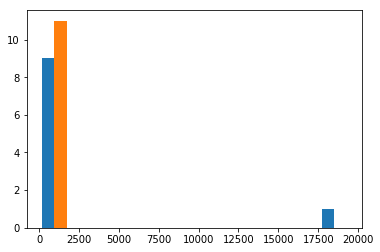

In [35]:
import matplotlib.pyplot as plt
plt.hist(np.histogram(mc))